# Scalar Bilevel ROF Single Gaussian SMILEY
We will solve the following bilevel problem

$$
\min_\lambda \|\hat{u}-z\|^2 + \beta\lambda^2\\
\text{s.t. } \hat{u} = arg\min_u \frac{\lambda}{2}\|u-f\|^2+\|\mathbb{K} u\|_{2,1} 
$$

We will use a small dataset of one sample contaminated with gaussian noise to learn the optimal parameter for the ROF image denoising model.

In [1]:
include("../../src/BilevelImagingParameterLearning.jl")
using .BilevelImagingParameterLearning

In [2]:
using LinearAlgebra, StructuredOptimization, AbstractOperators, Plots, Distributed, Images, ImageQualityIndexes, JLD

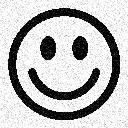

In [3]:
# Noisy image
f = datasetimage("1_noisy","../../datasets/smiley_dataset")
Gray.(f)

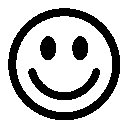

In [4]:
# Ground truth
z = datasetimage("smiley","../../datasets/smiley_dataset")
Gray.(z)

In [5]:
println("SSIM: ",ssim(f,z))
println("PSNR: ",psnr(f,z))

SSIM: 0.5566701208518678
PSNR: 22.994831253080182


## Lower Level Solver and Upper Level Cost Function
First, we will plot the cost function to see the form it has for this particular problem

In [6]:
# Lower Level Solver
function lower_level_solver(u,f,λ,K)
    @minimize λ*ls(-(1/λ)*K'*u+f) + conj(norm(u,2,1,2)) with ForwardBackward(tol = 1e-4, gamma = 1/8, fast = true) 
    return -(1/λ)*K'*(~u)+f
end

# Upper level cost
function upper_level_cost(u,z,λ,α)
    return 0.5*norm(u[:]-z[:])^2 + 0.5*α*norm(λ)^2
end

upper_level_cost (generic function with 1 method)

In [7]:
K = Variation(size(f)) # Define the finite differences gradient operator
u = Variable(size(K,1)...)
α = 0.1;

In [42]:
step = 0.5
lambda_max = 40.0
lambda_min = 1.0
lambda_range = lambda_min:step:lambda_max
costs = Float64[]
ssims = Float64[]
@distributed for λ in lambda_range
    u_h = lower_level_solver(u,f,λ,K)
    push!(costs,upper_level_cost(u_h,z,λ,α))
    push!(ssims,ssim(u_h,z))
    if λ % 10 == 0
        print("$(round(λ,digits=3)), ")
    end
end
println("done")

done10.0, 


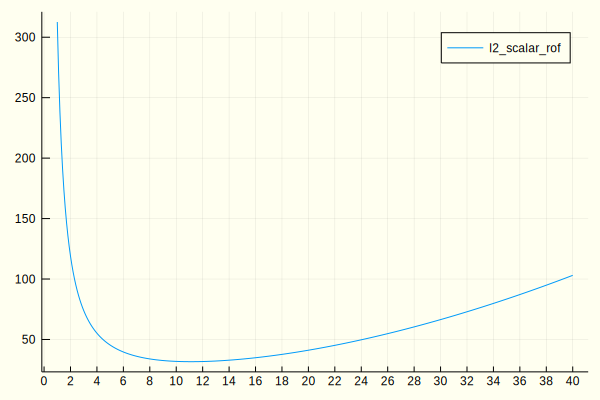

In [33]:
plot(lambda_range,costs,label="l2_scalar_rof", xticks = 0:2:lambda_max, background_color = :ivory)

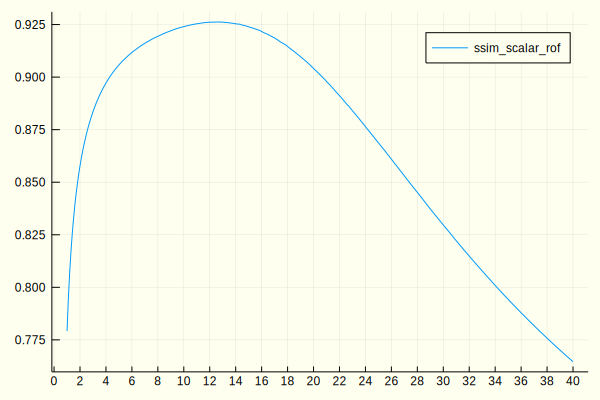

In [35]:
plot(lambda_range,ssims,label="ssim_scalar_rof",xticks = 0:2:lambda_max, background_color = :ivory)

In [11]:
# Saving generated data
using JLD
save("smiley_scalar_rof_cost.jld", "lambda", lambda_range, "costs", costs, "ssims",ssims)

## Gradient Calculation

In [44]:
include("gradient_solver.jl")

gradient_solver (generic function with 1 method)

In [47]:
λ = 2
∇ = gradient_matrix(size(f))
u_h= lower_level_solver(u,f,λ,K)
grad = gradient_solver(u_h,f,z,λ,α,K,∇)

-61.09368212664034

In [51]:
step = 0.5
lambda_max = 20.0
lambda_min = 1.0
lambda_range = lambda_min:step:lambda_max
grads = Float64[]
@distributed for λ in lambda_range
    u_h = lower_level_solver(u,f,λ,K)
    g = gradient_solver(u_h,f,z,λ,α,K,∇)
    push!(grads,g)
    if λ % 5 == 0
        print("$(round(λ,digits=3)), ")
    end
end

5.0, 10.0, 15.0, 20.0, 

Task (done) @0x000000011f06e1d0

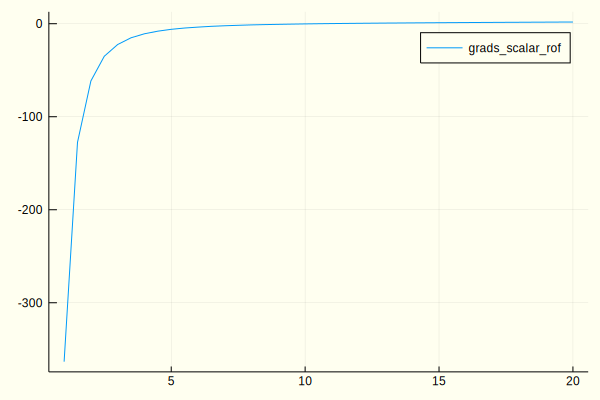

In [52]:
plot(lambda_range,grads,label="grads_scalar_rof", background_color = :ivory)

## Solving Bilevel Problem
We will define a numerical strategy based on an inexact Trust Region method to solve the bilevel problem. First, we need to define a gradient calculation

In [11]:
include("trust_region_solver.jl")

trust_region_solver (generic function with 3 methods)

In [12]:
lambda_0 = 5
radius_0 = 0.1
tol = 1e-6
check = 1;

In [13]:
model = 1
lambda_opt_1 = trust_region_solver(lower_level_solver,upper_level_cost,lambda_0,α,f,z,radius_0,tol,model,check)

TR Iteration 1: 	lambda = 5.0, rho_k = 1.176, radius = 0.1, g_k = -6.058, s_k = 0.1, H_k = 0.0
TR Iteration 2: 	lambda = 5.1, rho_k = 1.156, radius = 0.2, g_k = -5.701, s_k = 0.2, H_k = 0.0
TR Iteration 3: 	lambda = 5.3, rho_k = 1.105, radius = 0.4, g_k = -5.134, s_k = 0.4, H_k = 0.0
TR Iteration 4: 	lambda = 5.7, rho_k = 1.023, radius = 0.8, g_k = -4.158, s_k = 0.8, H_k = 0.0
TR Iteration 5: 	lambda = 6.5, rho_k = 0.875, radius = 1.6, g_k = -2.808, s_k = 1.6, H_k = 0.0
TR Iteration 6: 	lambda = 8.1, rho_k = 0.537, radius = 3.2, g_k = -1.228, s_k = 3.2, H_k = 0.0
TR Iteration 7: 	lambda = 11.3, rho_k = -9.149, radius = 6.4, g_k = 0.248, s_k = -6.4, H_k = 0.0
TR Iteration 8: 	lambda = 11.3, rho_k = -2.838, radius = 3.2, g_k = 0.232, s_k = -3.2, H_k = 0.0
TR Iteration 9: 	lambda = 11.3, rho_k = -0.981, radius = 1.6, g_k = 0.253, s_k = -1.6, H_k = 0.0
TR Iteration 10: 	lambda = 11.3, rho_k = -0.363, radius = 0.8, g_k = 0.231, s_k = -0.8, H_k = 0.0
TR Iteration 11: 	lambda = 11.3, rho_k = 

11.100000000000001

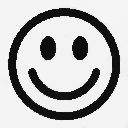

In [14]:
u_opt_1 = lower_level_solver(u,f,lambda_opt_1,K)
Gray.(u_opt_1)

In [15]:
println(ssim(u_opt_1,z))
println(ssim(f,z))

0.925694205819874
0.5566701208518678


In [17]:
model = 2 #SR1 Model
lambda_opt_2 = trust_region_solver(lower_level_solver,upper_level_cost,lambda_0,α,f,z,radius_0,tol,model,check)

TR Iteration 1: 	lambda = 5.0, rho_k = 1.177, radius = 0.1, g_k = -6.058, s_k = 0.1, H_k = 0.1
TR Iteration 2: 	lambda = 5.1, rho_k = 1.233, radius = 0.2, g_k = -5.701, s_k = 0.2, H_k = 3.57
TR Iteration 3: 	lambda = 5.3, rho_k = 1.242, radius = 0.4, g_k = -5.134, s_k = 0.4, H_k = 2.84
TR Iteration 4: 	lambda = 5.7, rho_k = 1.337, radius = 0.8, g_k = -4.158, s_k = 0.8, H_k = 2.44
TR Iteration 5: 	lambda = 6.5, rho_k = 1.472, radius = 1.6, g_k = -2.808, s_k = 1.151, H_k = 1.69
TR Iteration 6: 	lambda = 7.6509, rho_k = 1.51, radius = 3.2, g_k = -1.575, s_k = 0.933, H_k = 1.07
TR Iteration 7: 	lambda = 8.5843, rho_k = 1.629, radius = 6.4, g_k = -0.908, s_k = 0.848, H_k = 0.71
TR Iteration 8: 	lambda = 9.4325, rho_k = 2.084, radius = 12.8, g_k = -0.448, s_k = 0.627, H_k = 0.54
TR Iteration 9: 	lambda = 10.0595, rho_k = 2.957, radius = 25.6, g_k = -0.19, s_k = 0.35, H_k = 0.41
TR Iteration 10: 	lambda = 10.4096, rho_k = 12.532, radius = 51.2, g_k = -0.042, s_k = 0.102, H_k = 0.42
TR Iterati

10.73766197171533

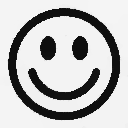

In [20]:
u_opt_2 = lower_level_solver(u,f,lambda_opt_2,K)
Gray.(u_opt_2)

In [22]:
println(ssim(u_opt_2,z))
println(ssim(f,z))

0.9252874335398438
0.5566701208518678


In [23]:
model = 3 #SR1 Model
lambda_opt_3 = trust_region_solver(lower_level_solver,upper_level_cost,lambda_0,α,f,z,radius_0,tol,model,check)

TR Iteration 1: 	lambda = 5.0, rho_k = 1.177, radius = 0.1, g_k = -6.058, s_k = 0.1, H_k = 0.1
TR Iteration 2: 	lambda = 5.1, rho_k = 1.233, radius = 0.2, g_k = -5.701, s_k = 0.2, H_k = 3.57
TR Iteration 3: 	lambda = 5.3, rho_k = 1.242, radius = 0.4, g_k = -5.134, s_k = 0.4, H_k = 2.84
TR Iteration 4: 	lambda = 5.7, rho_k = 1.337, radius = 0.8, g_k = -4.158, s_k = 0.8, H_k = 2.44
TR Iteration 5: 	lambda = 6.5, rho_k = 1.472, radius = 1.6, g_k = -2.808, s_k = 1.151, H_k = 1.69
TR Iteration 6: 	lambda = 7.6509, rho_k = 1.51, radius = 3.2, g_k = -1.575, s_k = 0.933, H_k = 1.07
TR Iteration 7: 	lambda = 8.5843, rho_k = 1.629, radius = 6.4, g_k = -0.908, s_k = 0.848, H_k = 0.71
TR Iteration 8: 	lambda = 9.4325, rho_k = 2.084, radius = 12.8, g_k = -0.448, s_k = 0.627, H_k = 0.54
TR Iteration 9: 	lambda = 10.0595, rho_k = 2.957, radius = 25.6, g_k = -0.19, s_k = 0.35, H_k = 0.41
TR Iteration 10: 	lambda = 10.4096, rho_k = 12.532, radius = 51.2, g_k = -0.042, s_k = 0.102, H_k = 0.42
TR Iterati

TR Iteration 81: 	lambda = 10.5154, rho_k = 7.29, radius = 6553.6, g_k = 0.007, s_k = -0.016, H_k = 5.09
TR Iteration 82: 	lambda = 10.4998, rho_k = 53.267, radius = 13107.2, g_k = -0.005, s_k = 0.001, H_k = 0.78
TR Iteration 83: 	lambda = 10.5008, rho_k = -288.157, radius = 26214.4, g_k = -0.003, s_k = 0.004, H_k = 1.95
TR Iteration 84: 	lambda = 10.5008, rho_k = -223.532, radius = 13107.2, g_k = 0.002, s_k = -0.001, H_k = 1.95
TR Iteration 85: 	lambda = 10.5008, rho_k = 116.944, radius = 6553.6, g_k = -0.004, s_k = 0.002, H_k = 1.95
TR Iteration 86: 	lambda = 10.5031, rho_k = 49.947, radius = 13107.2, g_k = -0.009, s_k = 0.005, H_k = 1.95
TR Iteration 87: 	lambda = 10.5079, rho_k = 256.219, radius = 26214.4, g_k = -0.002, s_k = 0.001, H_k = 1.61
TR Iteration 88: 	lambda = 10.5088, rho_k = 126.814, radius = 52428.8, g_k = -0.004, s_k = 0.002, H_k = 1.61
TR Iteration 89: 	lambda = 10.5111, rho_k = -1019.353, radius = 104857.6, g_k = 0.001, s_k = -0.0, H_k = 1.87
TR Iteration 90: 	lambd

10.511096744870509

In [ ]:
u_opt_3 = lower_level_solver(u,f,lambda_opt_3,K)
Gray.(u_opt_3)